In [1]:
#import Clonal_tracing_class as ct
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import os
from scipy.stats.stats import pearsonr
import help_functions as hf
import sys
#%matplotlib inline

# Code purpose
We compute p values for clonal correlations observed in the clonal data, using a graphic model mentioned in the theory supplement. 
Specifically, we use clonal data obtained with droptout correciton in previous steps, thus the name "withDropOutCorrection".
This is achieved by using proper file directory "mydir", i.e.,   mydir="./Combined_T1T2/Hamming_4/NoDropoutCorrection/".  Specifically, we are using clonal generated using Hamming distance=4. You can also change the directory to using other Hamming distance. However, the final clones are very robust to this parameter. So it makes no difference. 

In [2]:
mydir="./Combined_T1T2/Hamming_4/NoDropoutCorrection/"

# Initialization

In [3]:
P_ex=0.56 # 0.7, the probability to get extracted from the bone marrow +FACS
P_sp=0.5 # 0.5, the probability to be sampled when splitting the sample half by half for seconary transplantation
P_indrops=0.5; # the portion of the sample splitted for inDrops
P_nd=0.7 # 0.7, the non-dropout probability during Sequencing
P_eg=0.137 #chance to be successfully engrafted, 0.086 for this DropoutCorrected data, and 0.137 for NoCorrection data 
alpha=0.887 #0.887 for NoCoorection approach; 0.91 for DropoutCorrected clustering. P_00 is 1-alpha in our theory note
N_initial_clone=465 # T1_clone_number/(1-P_00);  262 for DropoutCorrected clones, and 465 for the NoCorrection clones
Is_null_model=1; # default 1
my_list=[0.1,0.2,0.5,1.01,2,5,10,20]; # for binning the data
plot_fig=[1,3]; # plot figures with caption R1 and R2

In [4]:
fig_dir=mydir+"figure/T2_R1T2_R2/"
data_dir=mydir+"analysis/"
#data_dir=mydir+"analysis/T1_T2_/"
if not os.path.exists(fig_dir):
    !mkdir $fig_dir;
    
if not os.path.exists(data_dir):
    !mkdir $data_dir;

sys.path.append(data_dir) #expand the searching path


# import relevant parameters from another program
import corr_variables_etc as rp
cutoff_small=rp.cutoff_small;
cutoff_large=rp.cutoff_large;
pseudo_act_exp=rp.pseudo_act_exp;
threshold=rp.threshold;

P_array=[P_ex,P_indrops,P_sp,P_nd,P_eg];

In [5]:
threshold

1.9

In [6]:
rp.clone_N_T1

414

# Loading data

In [7]:
all_data=np.load(data_dir+"all_data.npy");
T1_HSC_info_0=all_data[:,0];
T1_Kit_info_0=all_data[:,1];
# only keep the 1T data set
index=(T1_HSC_info_0+T1_Kit_info_0)>0;
T1_HSC_info_0=T1_HSC_info_0[index];
T1_Kit_info_0=T1_Kit_info_0[index];

# a quick check of consistency
corr_HSC_Kit_T1=pearsonr(T1_HSC_info_0,T1_Kit_info_0)[0];
print("Corr (T1HSC-T1Kit):",corr_HSC_Kit_T1)
print("Total clone number is",len(T1_HSC_info_0))

# add the missed clones
T1_HSC_info=np.concatenate((np.array(T1_HSC_info_0),np.zeros(int(np.round((1-alpha)/(alpha)*len(T1_HSC_info_0))))));
T1_Kit_info=np.concatenate((np.array(T1_Kit_info_0),np.zeros(int(np.round((1-alpha)/(1-alpha)*len(T1_Kit_info_0))))));

Corr (T1HSC-T1Kit): 0.5589642712091782
Total clone number is 414


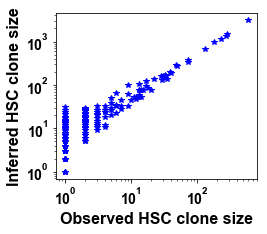

In [8]:
# infer the HSC clone size inside the mouse
inferred_T1_HSC_info=hf.inferred_clone_size(T1_HSC_info,P_ex*P_sp*P_nd)
inferred_T1_Kit_info=hf.inferred_clone_size(T1_Kit_info,P_ex*P_sp*P_nd)
inferred_T1_HSC_info=inferred_T1_HSC_info.astype(int);
inferred_T1_Kit_info=inferred_T1_Kit_info.astype(int);


# inferred_T2_HSC_info=hf.inferred_clone_size(T2_HSC_info,P_ex*P_nd)
# inferred_T2_Kit_info=hf.inferred_clone_size(T2_Kit_info,P_ex*P_nd)
# # assume the ?% of engrafted HSC die without giving rise to progenies
# inferred_T2_HSC_info=np.concatenate((np.array(inferred_T2_HSC_info),np.zeros(int(np.round(P_failed_expand*len(inferred_T2_HSC_info))))));
# inferred_T2_HSC_info=inferred_T2_HSC_info.astype(int);
# inferred_T2_Kit_info=np.concatenate((np.array(inferred_T2_Kit_info),np.zeros(int(np.round(P_failed_expand*len(inferred_T2_Kit_info))))));
# inferred_T2_Kit_info=inferred_T2_Kit_info.astype(int);


%run my_fig_config_0
fig = plt.figure(figsize=(4,3.5)); ax = fig.add_subplot(1, 1, 1)
ax.plot(T1_HSC_info,inferred_T1_HSC_info[0:len(T1_HSC_info)],"*",color="b")
ax.set_xlabel("Observed HSC clone size");
ax.set_ylabel("Inferred HSC clone size");
ax.set_xscale("log")
ax.set_yscale('log')
fig.tight_layout();
fig.savefig(fig_dir+"Observed_inferred_HSC_clone_size.eps")

# %run my_fig_config
# ax.plot(T1_Kit_info,inferred_T1_Kit_info[0:len(T1_HSC_info)],"*",color="b")
# ax.set_xlabel("Observed Kit clone size");
# ax.set_ylabel("Inferred Kit clone size");
# ax.set_xscale("log")
# ax.set_yscale('log')
# fig.tight_layout();
# fig.savefig(fig_dir+"Observed_inferred_Kit_clone_size.eps")


In [9]:
# ##  test the effect of correlated-input fluctuations [Increase the clone_upper_size can enhance correlation]
# tot_run=1000;
# clone_upper_size=100;
# x1=np.zeros(tot_run)
# x2=np.zeros(tot_run)
# corr_array=np.zeros(tot_run)
# L=100;
# for l in range(tot_run):
#     for k in range(L):
#         engrafted_N=np.random.randint(1,clone_upper_size);
#         #print(engrafted_N)
#         x1[k]=sum([np.random.choice(inferred_T1_HSC_info) for j in range(engrafted_N)])
#         x2[k]=sum([np.random.choice(inferred_T1_HSC_info) for j in range(engrafted_N)])
#     corr_array[l]=pearsonr(x1,x2)[0];
    
# plt.hist(corr_array,50,color='r');

# Analysis for the inferred data

In [10]:
# test all kinds of correlation between clone sizes

#shared_clone_size=len(inferred_T1_HSC_info);
#hf.plot_figs_correlation(inferred_T1_HSC_info, inferred_T1_Kit_info, inferred_T2_HSC_info, inferred_T2_Kit_info, fig_dir)


In [11]:
# test correlation between expansion capacity in T1 and T2

#cutoff_small=10;cutoff_large=300
#hf.plot_figs_expansion_activity(cutoff_small, cutoff_large, inferred_T1_HSC_info, inferred_T1_Kit_info, inferred_T2_HSC_info, inferred_T2_Kit_info, fig_dir)

In [12]:
# total clone expansion in T2
# [mean_ratio,std_ratio]=hf.plot_figs_1Tactivity_2Texpansion(cutoff_small, pseudo_act_exp, threshold, inferred_T1_HSC_info, inferred_T1_Kit_info, inferred_T2_HSC_info, inferred_T2_Kit_info, fig_dir)


In [13]:
# result=hf.plot_average_expansion(potency_T1[index_large_HSC],expansion_T2[index_large_HSC],my_list,1,fig_dir);
# #plt.plot(result[:,0],result[:,1],'*r');
# #plt.plot(result[:,0],result[:,2],'*r');

# %run my_fig_config
# ax.errorbar(result[:,0],result[:,1],result[:,2], fmt='.k',ecolor='gray')
# ax.set_xlabel("1T activity");
# ax.set_ylabel("2T expansion");
# fig.tight_layout();
# #ax.set_yscale('log')
# ax.set_ylim((-0.1,15))
# ax.set_xscale('log')
# fig.savefig(fig_dir+"potency_1T2T_mean_std2.eps")


## selecting model for analysis

In [14]:
if Is_null_model:
    my_model=hf.multi_clone_model_sampling_M1_kit_two_mouse;
    data=my_model(N_initial_clone,P_array,inferred_T1_HSC_info,inferred_T1_Kit_info);
else:
    my_model=hf.multi_clone_model_activity_based_sampling_M1_Kit;
    expan_thres=1;
    activ_thres=1;
    data=my_model(N_initial_clone,P_array,expan_thres,activ_thres,inferred_T1_HSC_info,inferred_T1_Kit_info);   
        
        
simu_HSC_T1=np.array(data[:,0]);
simu_HSC_T2R1=np.array(data[:,1]);
simu_HSC_T2R2=np.array(data[:,2]);
simu_Kit_T1=np.array(data[:,3]);
simu_Kit_T2R1=np.array(data[:,4]);
simu_Kit_T2R2=np.array(data[:,5]);
simu_T1=simu_HSC_T1+simu_Kit_T1
simu_T2R1=simu_HSC_T2R1+simu_Kit_T2R1
simu_T2R2=simu_HSC_T2R2+simu_Kit_T2R2
    


N_shared_clone=sum((simu_T1>0) & (simu_T2R1>0))
N_clone_T2R1=sum(simu_T2R1>0);
N_clone_T1=sum(simu_T1>0);
N_clone_T2R2=sum(simu_T2R2>0);
print("Shared clone number:",N_shared_clone);
print("Clone number in T1:",N_clone_T1)
print("Clone number in T2-R1:",N_clone_T2R1)
print("Clone number in T2-R2:",N_clone_T2R2)
print("Total initial clone number:",len(data[:,0]))

Shared clone number: 89
Clone number in T1: 412
Clone number in T2-R1: 91
Clone number in T2-R2: 94
Total initial clone number: 465


In [15]:
# hf.plot_figs_correlation(plot_fig,simu_HSC_T1, simu_Kit_T1,simu_HSC_T2R1,simu_Kit_T2R1, fig_dir);

# Ensembles of simulations

In [16]:
## Run N times to get a distribution of the T1-T2 correlation, then estimate the P value
Ensemble_N=10000;
plot_fig=0;

N_clone_T1_array=np.zeros(Ensemble_N);
N_clone_T2R1_array=np.zeros(Ensemble_N);
N_clone_T2R2_array=np.zeros(Ensemble_N);
N_clone_T2_array=np.zeros(Ensemble_N);
N_shared_clone_array_T1T2=np.zeros(Ensemble_N);
N_shared_clone_array_T1R1R2=np.zeros(Ensemble_N);

Corr_simu_T1HSC_T2HSC_array=np.zeros(Ensemble_N);
Corr_simu_T1HSC_T2Kit_array=np.zeros(Ensemble_N);
Corr_simu_T2HSC_T2Kit_array=np.zeros(Ensemble_N);
Corr_simu_T1Kit_T2Kit_array=np.zeros(Ensemble_N);
Corr_simu_T1HSC_T1Kit_array=np.zeros(Ensemble_N);
Corr_simu_T1Kit_T2HSC_array=np.zeros(Ensemble_N);
Corr_simu_T1tot_T2tot_array=np.zeros(Ensemble_N);

Corr_simu_T2R1HSC_T2R2HSC_array=np.zeros(Ensemble_N);
Corr_simu_T2R1HSC_T2R2Kit_array=np.zeros(Ensemble_N);
Corr_simu_T2R1Kit_T2R2Kit_array=np.zeros(Ensemble_N);
Corr_simu_T2R1tot_T2R2tot_array=np.zeros(Ensemble_N);
Corr_simu_T2R1HSC_T2R1Kit_array=np.zeros(Ensemble_N);
Corr_simu_T2R1T2R2_expansion=np.zeros(Ensemble_N);

Corr_simu_T1T2potency_array=np.zeros(Ensemble_N);
Corr_simu_T1T2expansion_array=np.zeros(Ensemble_N);
Corr_simu_T1potency_T2expansion_array=np.zeros(Ensemble_N);
Corr_simu_T1expansion_T2potency_array=np.zeros(Ensemble_N);

Mean_ratio_HSC_array_T1T2=np.zeros(Ensemble_N);
Mean_ratio_Kit_array_T1T2=np.zeros(Ensemble_N);
Mean_ratio_array_T1T2=np.zeros(Ensemble_N);
std_ratio_HSC_array_T1T2=np.zeros(Ensemble_N);
std_ratio_Kit_array_T1T2=np.zeros(Ensemble_N);
std_ratio_array_T1T2=np.zeros(Ensemble_N);
finer_mean_std_T1T2=np.zeros((len(my_list),3));

Mean_ratio_array_T1R2=np.zeros(Ensemble_N);
Mean_ratio_array_T1R1=np.zeros(Ensemble_N);
std_ratio_array_T1R2=np.zeros(Ensemble_N);
std_ratio_array_T1R1=np.zeros(Ensemble_N);
Mean_ratio_array_HSC_T1R2=np.zeros(Ensemble_N);
Mean_ratio_array_HSC_T1R1=np.zeros(Ensemble_N);
std_ratio_array_HSC_T1R2=np.zeros(Ensemble_N);
std_ratio_array_HSC_T1R1=np.zeros(Ensemble_N);
Mean_ratio_array_Kit_T1R2=np.zeros(Ensemble_N);
Mean_ratio_array_Kit_T1R1=np.zeros(Ensemble_N);
std_ratio_array_Kit_T1R2=np.zeros(Ensemble_N);
std_ratio_array_Kit_T1R1=np.zeros(Ensemble_N);
#Corr_simu_T1potency_T2expansion_array=np.zeros(Ensemble_N);

        
for k in range(Ensemble_N):
    
    # infer the HSC clone size inside the mouse
    inferred_T1_HSC_info=hf.inferred_clone_size(T1_HSC_info,P_ex*P_sp*P_nd)
    inferred_T1_Kit_info=hf.inferred_clone_size(T1_Kit_info,P_ex*P_sp*P_nd)
    inferred_T1_HSC_info=inferred_T1_HSC_info.astype(int);
    inferred_T1_Kit_info=inferred_T1_Kit_info.astype(int);
    
    if Is_null_model:
        data=my_model(N_initial_clone,P_array,inferred_T1_HSC_info,inferred_T1_Kit_info);
    else:
        data=my_model(N_initial_clone,P_array,expan_thres,activ_thres,inferred_T1_HSC_info,inferred_T1_Kit_info);
        
    simu_HSC_T1=np.array(data[:,0]);
    simu_HSC_T2R1=np.array(data[:,1]);
    simu_HSC_T2R2=np.array(data[:,2]);
    simu_HSC_T2=simu_HSC_T2R1+simu_HSC_T2R2;
    simu_Kit_T1=np.array(data[:,3]);
    simu_Kit_T2R1=np.array(data[:,4]);
    simu_Kit_T2R2=np.array(data[:,5]);
    simu_Kit_T2=simu_Kit_T2R1+simu_Kit_T2R2;
    simu_T1=simu_HSC_T1+simu_Kit_T1
    simu_T2R1=simu_HSC_T2R1+simu_Kit_T2R1
    simu_T2R2=simu_HSC_T2R2+simu_Kit_T2R2
    simu_T2=simu_T2R1+simu_T2R2

    ##### 1T-2T 
    N_clone_T1_array[k]=sum(simu_T1>0);    
    N_clone_T2_array[k]=sum(simu_T2>0);
    N_shared_clone_array_T1T2[k]=sum((simu_T1>0) & (simu_T2>0));
    Corr_simu_T1HSC_T2HSC_array[k]=pearsonr(simu_HSC_T1,simu_HSC_T2)[0];
    Corr_simu_T1HSC_T2Kit_array[k]=pearsonr(simu_HSC_T1,simu_Kit_T2)[0];
    Corr_simu_T2HSC_T2Kit_array[k]=pearsonr(simu_HSC_T2,simu_Kit_T2)[0];
    Corr_simu_T1Kit_T2Kit_array[k]=pearsonr(simu_Kit_T1,simu_Kit_T2)[0];
    Corr_simu_T1HSC_T1Kit_array[k]=pearsonr(simu_HSC_T1,simu_Kit_T1)[0];
    Corr_simu_T1Kit_T2HSC_array[k]=pearsonr(simu_Kit_T1,simu_HSC_T2)[0];
    Corr_simu_T1tot_T2tot_array[k]=pearsonr(simu_T1,simu_T2)[0];

    potency_T1=(simu_Kit_T1+pseudo_act_exp)/(simu_HSC_T1+pseudo_act_exp);
    expansion_T2=(simu_T2+pseudo_act_exp)/(simu_HSC_T1+pseudo_act_exp);
    expansion_T2_HSC=(simu_HSC_T2+pseudo_act_exp)/(simu_HSC_T1+pseudo_act_exp);
    expansion_T2_Kit=(simu_Kit_T2+pseudo_act_exp)/(simu_HSC_T1+pseudo_act_exp);
    expansion_T1=(simu_HSC_T1+pseudo_act_exp)/(1+pseudo_act_exp);
    potency_T2=(simu_Kit_T2+pseudo_act_exp)/(simu_HSC_T2+pseudo_act_exp);
    used_clone_index_1=(simu_HSC_T1>=cutoff_small) #cutoff_small=0 is used in the paper, so all data is used
    
# statistical significance of T1 activity-T2 expansion relation
    data_1=expansion_T2[used_clone_index_1][potency_T1[used_clone_index_1]<threshold]
    data_2=expansion_T2[used_clone_index_1][potency_T1[used_clone_index_1]>=threshold]
    Mean_ratio_array_T1T2[k]=np.mean(data_1)/np.mean(data_2);
    std_ratio_array_T1T2[k]=np.std(data_1)/np.std(data_2);

# statistical significance of T1 activity-T2 HSC expansion relation
    data_1=expansion_T2_HSC[used_clone_index_1][potency_T1[used_clone_index_1]<threshold]
    data_2=expansion_T2_HSC[used_clone_index_1][potency_T1[used_clone_index_1]>=threshold]
    Mean_ratio_HSC_array_T1T2[k]=np.mean(data_1)/np.mean(data_2);
    std_ratio_HSC_array_T1T2[k]=np.std(data_1)/np.std(data_2);
    
# statistical significance of T1 activity-T2 HSC expansion relation
    data_1=expansion_T2_Kit[used_clone_index_1][potency_T1[used_clone_index_1]<threshold]
    data_2=expansion_T2_Kit[used_clone_index_1][potency_T1[used_clone_index_1]>=threshold]
    Mean_ratio_Kit_array_T1T2[k]=np.mean(data_1)/np.mean(data_2);
    std_ratio_Kit_array_T1T2[k]=np.std(data_1)/np.std(data_2);
    

    Corr_simu_T1T2expansion_array[k]=pearsonr(expansion_T1[used_clone_index_1],expansion_T2[used_clone_index_1])[0];
    Corr_simu_T1expansion_T2potency_array[k]=pearsonr(expansion_T1[used_clone_index_1],potency_T2[used_clone_index_1])[0];
    Corr_simu_T1T2potency_array[k]=pearsonr(potency_T1[used_clone_index_1],potency_T2[used_clone_index_1])[0];
    Corr_simu_T1potency_T2expansion_array[k]=pearsonr(potency_T1[used_clone_index_1],expansion_T2[used_clone_index_1])[0];

    plot_fig1=[0,0];
    finer_mean_std_T1T2+=hf.plot_average_expansion(potency_T1[used_clone_index_1],expansion_T2[used_clone_index_1],my_list,plot_fig1,fig_dir)

    
    #### R1-R2
    N_clone_T2R1_array[k]=sum(simu_T2R1>0);
    N_clone_T2R2_array[k]=sum(simu_T2R2>0);
    N_shared_clone_array_T1R1R2[k]=sum((simu_T1>0) & (simu_T2R1>0) & (simu_T2R2>0));
    Corr_simu_T2R1HSC_T2R2HSC_array[k]=pearsonr(simu_HSC_T2R1,simu_HSC_T2R2)[0];
    Corr_simu_T2R1HSC_T2R2Kit_array[k]=pearsonr(simu_HSC_T2R1,simu_Kit_T2R2)[0];
    Corr_simu_T2R1Kit_T2R2Kit_array[k]=pearsonr(simu_Kit_T2R1,simu_Kit_T2R2)[0];
    Corr_simu_T2R1HSC_T2R1Kit_array[k]=pearsonr(simu_HSC_T2R1,simu_Kit_T2R1)[0];
    Corr_simu_T2R1tot_T2R2tot_array[k]=pearsonr(simu_T2R1,simu_T2R2)[0];

    
    expansion_T2R1=(simu_T2R1+pseudo_act_exp)/(simu_HSC_T1+pseudo_act_exp);
    expansion_HSC_T2R1=(simu_HSC_T2R1+pseudo_act_exp)/(simu_HSC_T1+pseudo_act_exp);
    expansion_Kit_T2R1=(simu_Kit_T2R1+pseudo_act_exp)/(simu_HSC_T1+pseudo_act_exp);
    expansion_T2R2=(simu_T2R2+pseudo_act_exp)/(simu_HSC_T1+pseudo_act_exp);
    expansion_HSC_T2R2=(simu_HSC_T2R2+pseudo_act_exp)/(simu_HSC_T1+pseudo_act_exp);
    expansion_Kit_T2R2=(simu_Kit_T2R2+pseudo_act_exp)/(simu_HSC_T1+pseudo_act_exp);
    used_clone_index_1=(simu_HSC_T1>=cutoff_small) 
    
    # statistical significance of T1 activity-T2R1 expansion relation
    data_1=expansion_T2R1[used_clone_index_1][potency_T1[used_clone_index_1]<threshold]
    data_2=expansion_T2R1[used_clone_index_1][potency_T1[used_clone_index_1]>=threshold]
    Mean_ratio_array_T1R1[k]=np.mean(data_1)/np.mean(data_2);
    std_ratio_array_T1R1[k]=np.std(data_1)/np.std(data_2);

    data_1=expansion_HSC_T2R1[used_clone_index_1][potency_T1[used_clone_index_1]<threshold]
    data_2=expansion_HSC_T2R1[used_clone_index_1][potency_T1[used_clone_index_1]>=threshold]
    Mean_ratio_array_HSC_T1R1[k]=np.mean(data_1)/np.mean(data_2);
    std_ratio_array_HSC_T1R1[k]=np.std(data_1)/np.std(data_2);
    
    data_1=expansion_Kit_T2R1[used_clone_index_1][potency_T1[used_clone_index_1]<threshold]
    data_2=expansion_Kit_T2R1[used_clone_index_1][potency_T1[used_clone_index_1]>=threshold]
    Mean_ratio_array_Kit_T1R1[k]=np.mean(data_1)/np.mean(data_2);
    std_ratio_array_Kit_T1R1[k]=np.std(data_1)/np.std(data_2);
    
    # statistical significance of T1 activity-T2R2 expansion relation
    data_1=expansion_T2R2[used_clone_index_1][potency_T1[used_clone_index_1]<threshold]
    data_2=expansion_T2R2[used_clone_index_1][potency_T1[used_clone_index_1]>=threshold]
    Mean_ratio_array_T1R2[k]=np.mean(data_1)/np.mean(data_2);
    std_ratio_array_T1R2[k]=np.std(data_1)/np.std(data_2);

    data_1=expansion_HSC_T2R2[used_clone_index_1][potency_T1[used_clone_index_1]<threshold]
    data_2=expansion_HSC_T2R2[used_clone_index_1][potency_T1[used_clone_index_1]>=threshold]
    Mean_ratio_array_HSC_T1R2[k]=np.mean(data_1)/np.mean(data_2);
    std_ratio_array_HSC_T1R2[k]=np.std(data_1)/np.std(data_2);
    
    data_1=expansion_Kit_T2R2[used_clone_index_1][potency_T1[used_clone_index_1]<threshold]
    data_2=expansion_Kit_T2R2[used_clone_index_1][potency_T1[used_clone_index_1]>=threshold]
    Mean_ratio_array_Kit_T1R2[k]=np.mean(data_1)/np.mean(data_2);
    std_ratio_array_Kit_T1R2[k]=np.std(data_1)/np.std(data_2);
    
    Corr_simu_T2R1T2R2_expansion[k]=pearsonr(expansion_T2R1[used_clone_index_1],expansion_T2R2[used_clone_index_1])[0];
    

    
## There is NO indentation here
finer_mean_std_T1T2=finer_mean_std_T1T2/Ensemble_N;    


In [17]:
finer_mean_std_T1T2

array([[ 0.05      ,  5.93048386,  8.22523615],
       [ 0.14984   ,  4.78372687, 14.21158748],
       [ 0.35      ,  4.72733648, 24.51132016],
       [ 0.755     ,  5.13717023, 30.14075601],
       [ 1.505     ,  4.94751749, 26.33577834],
       [ 3.5       ,  5.03482021, 25.64608848],
       [ 7.5       ,  4.96507393, 15.70780241],
       [15.        ,  5.48208098, 11.83800803]])

Mean for 1T clone number:  412.4298
Standard deviation for 1T clone number:  7.396395876371139
Experimental value for 1T clone number:  414
P value for 1T clone number:  0.398
Mean for 2T clone number:  134.7405
Standard deviation for 2T clone number:  10.22462516427864
Experimental value for 2T clone number:  133
P value for 2T clone number:  0.45489999999999997
Mean for Clone # ratio: 2T/1T:  0.32672299271971167
Standard deviation for Clone # ratio: 2T/1T:  0.024410276759512066
Experimental value for Clone # ratio: 2T/1T:  0.321256038647343
P value for Clone # ratio: 2T/1T:  0.4145
Mean for Fraction of shared clone:  1.0485686598258714
Standard deviation for Fraction of shared clone:  0.020290047876026566
Experimental value for Fraction of shared clone:  2.19672131147541
P value for Fraction of shared clone:  0.0
Mean for Corr: HSC$^{1T}$-HSC$^{2T}$:  0.7347343027632187
Standard deviation for Corr: HSC$^{1T}$-HSC$^{2T}$:  0.1382522707246792
Experimental value for Corr: HSC$^{1T}$-HSC

/Users/shouwenwang/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


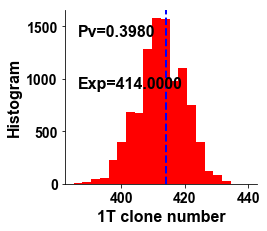

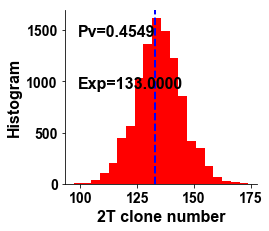

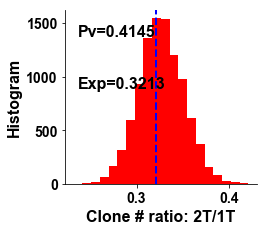

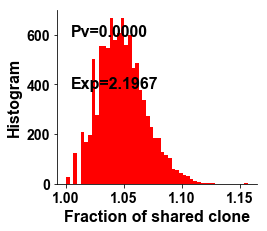

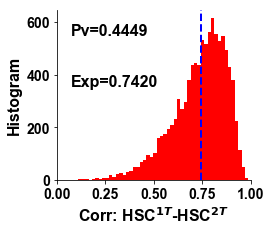

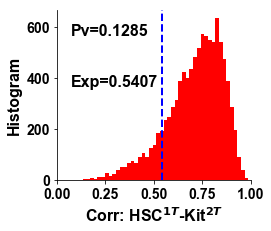

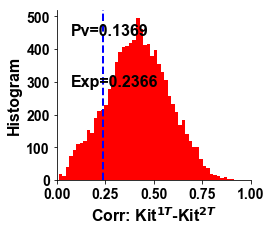

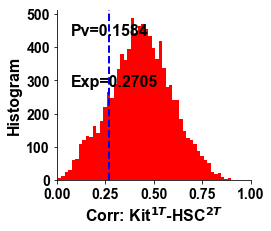

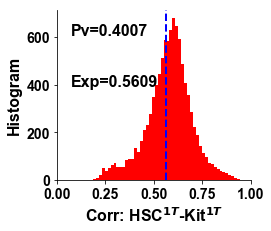

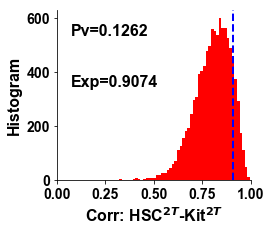

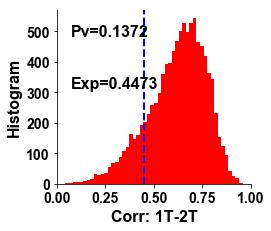

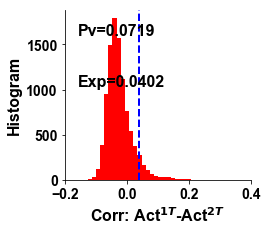

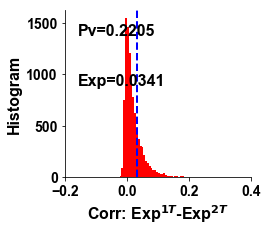

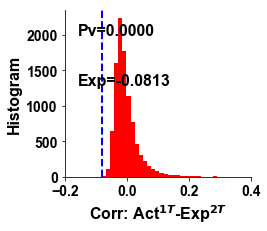

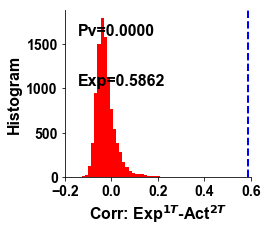

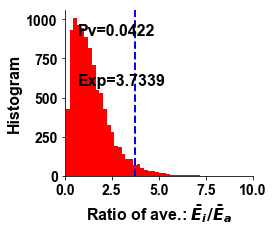

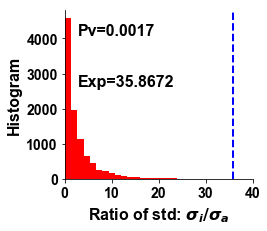

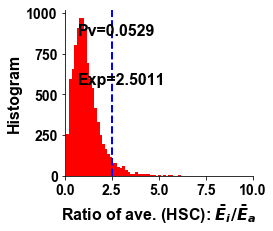

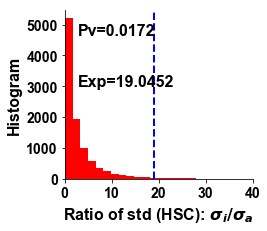

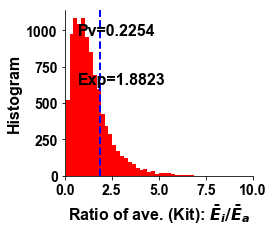

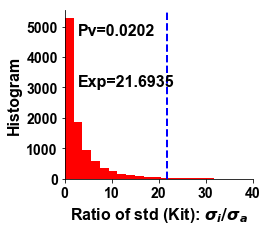

In [18]:
## for T1 and T2

simu_data=N_clone_T1_array;  bin_N=20; exp_point=rp.clone_N_T1; xlim=[]; xlabel="1T clone number";  
mean_std_T1_clone_size=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);


simu_data=N_clone_T2_array;  bin_N=20; exp_point=rp.clone_N_T2; xlim=[];xlabel="2T clone number"; 
mean_std_T2_clone_size=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=N_clone_T2_array/N_clone_T1_array;  bin_N=20; exp_point=rp.clone_N_T2/rp.clone_N_T1; xlim=[]; 
xlabel="Clone # ratio: 2T/1T"; file_name="Clone_N_ratio_2T_1T"
mean_std_T2_clone_size=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);


simu_data=N_clone_T2_array/N_shared_clone_array_T1T2;  bin_N=50; exp_point=134/61; xlim=[]; xlabel="Fraction of shared clone";  
mean_std_shared_clone=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);


simu_data=Corr_simu_T1HSC_T2HSC_array;  bin_N=50; exp_point=rp.corr_T1HSC_T2HSC; xlim=[0,1]; 
xlabel="Corr: HSC"+r"$^{1T}$"+"-HSC"+r"$^{2T}$";
mean_std_1THSC_2THSC=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);


simu_data=Corr_simu_T1HSC_T2Kit_array;  bin_N=50; exp_point=rp.corr_T1HSC_T2Kit; xlim=[0,1]; 
xlabel="Corr: HSC"+r"$^{1T}$"+"-Kit"+r"$^{2T}$";
mean_std_1THSC_2TKit=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);


simu_data=Corr_simu_T1Kit_T2Kit_array;  bin_N=50; exp_point=rp.corr_T1Kit_T2Kit; xlim=[0,1]; 
xlabel="Corr: Kit"+r"$^{1T}$"+"-Kit"+r"$^{2T}$";
mean_std_1TKit_2TKit=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);


simu_data=Corr_simu_T1Kit_T2HSC_array;  bin_N=50; exp_point=rp.corr_T1Kit_T2HSC; xlim=[0,1]; 
xlabel="Corr: Kit"+r"$^{1T}$"+"-HSC"+r"$^{2T}$"; 
mean_std_1TKit_2THSC=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);


simu_data=Corr_simu_T1HSC_T1Kit_array;  bin_N=50; exp_point=rp.corr_T1HSC_T1Kit; xlim=[0,1]; 
xlabel="Corr: HSC"+r"$^{1T}$"+"-Kit"+r"$^{1T}$"; 
mean_std_1THSC_1TKit=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T2HSC_T2Kit_array;  bin_N=50; exp_point=rp.corr_T2HSC_T2Kit; xlim=[0,1]; 
xlabel="Corr: HSC"+r"$^{2T}$"+"-Kit"+r"$^{2T}$"; 
mean_std_2THSC_2TKit=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T1tot_T2tot_array;  bin_N=50; exp_point=rp.corr_T1cloneT2clone; xlim=[0,1];
xlabel="Corr: 1T-2T"; 
mean_std_1T_2T=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T1T2potency_array;  bin_N=50; exp_point=rp.corr_T1actT2act; xlim=[-0.2,0.4]; 
xlabel="Corr: Act"+r"$^{1T}$"+"-Act"+r"$^{2T}$"; 
mean_std_1TAct_2TAct=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T1T2expansion_array;  bin_N=50; exp_point=rp.corr_T1expT2exp; xlim=[-0.2,0.4]; 
xlabel="Corr: Exp"+r"$^{1T}$"+"-Exp"+r"$^{2T}$"; 
mean_std_1TAct_2TAct=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T1potency_T2expansion_array;  bin_N=50; exp_point=rp.corr_T1actT2exp; xlim=[-0.2,0.4]; 
xlabel="Corr: Act"+r"$^{1T}$"+"-Exp"+r"$^{2T}$"; 
mean_std_1TAct_2TAct=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T1T2potency_array;  bin_N=50; exp_point=rp.corr_T1expT2act; xlim=[-0.2,0.6]; 
xlabel="Corr: Exp"+r"$^{1T}$"+"-Act"+r"$^{2T}$"; 
mean_std_1TAct_2TAct=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);


simu_data=Mean_ratio_array_T1T2;  bin_N=50; exp_point=rp.mean_ratio_T1T2; xlim=[0,10]; xlabel="Ratio of ave.: "+r"$\bar{E}_i/\bar{E}_a$"; file_name="mean_ratio"  
mean_std_mean_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=std_ratio_array_T1T2;  bin_N=50; exp_point=rp.std_ratio_T1T2; xlim=[0,40]; xlabel="Ratio of std: "+r"$\sigma_i/\sigma_a$"; file_name="Std_ratio"  
mean_std_std_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=Mean_ratio_HSC_array_T1T2;  bin_N=50; exp_point=rp.mean_ratio_HSC_T1T2; xlim=[0,10]; xlabel="Ratio of ave. (HSC): "+r"$\bar{E}_i/\bar{E}_a$"; file_name="mean_ratio_HSC"  
mean_std_mean_ratio_HSC=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=std_ratio_HSC_array_T1T2;  bin_N=50; exp_point=rp.std_ratio_HSC_T1T2; xlim=[0,40]; xlabel="Ratio of std (HSC): "+r"$\sigma_i/\sigma_a$"; file_name="Std_ratio_HSC"  
mean_std_std_ratio_HSC=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=Mean_ratio_Kit_array_T1T2;  bin_N=50; exp_point=rp.mean_ratio_Kit_T1T2; xlim=[0,10]; xlabel="Ratio of ave. (Kit): "+r"$\bar{E}_i/\bar{E}_a$"; file_name="mean_ratio_Kit"  
mean_std_mean_ratio_Kit=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=std_ratio_Kit_array_T1T2;  bin_N=50; exp_point=rp.std_ratio_Kit_T1T2; xlim=[0,40]; xlabel="Ratio of std (Kit): "+r"$\sigma_i/\sigma_a$"; file_name="Std_ratio_Kit"  
mean_std_std_ratio_Kit=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);


# simu_data=Size_win2_array;  bin_N=50; exp_point=0; xlim=[]; xlabel="Data N in Win 2"; file_name="Size_win2_array"  
# hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);


Mean for 1T clone number:  412.4298
Standard deviation for 1T clone number:  7.396395876371139
Experimental value for 1T clone number:  414
P value for 1T clone number:  0.398
Mean for R1 clone number:  87.7481
Standard deviation for R1 clone number:  8.609079299785778
Experimental value for R1 clone number:  87.5
P value for R1 clone number:  0.49229999999999996
Mean for Number of shared clone:  40.4498
Standard deviation for Number of shared clone:  6.1520793200348125
Experimental value for Number of shared clone:  27
P value for Number of shared clone:  0.013900000000000023
Mean for Corr: HSC$^{R1}$-HSC$^{R2}$:  0.41378869495453807
Standard deviation for Corr: HSC$^{R1}$-HSC$^{R2}$:  0.20324525553009878
Experimental value for Corr: HSC$^{R1}$-HSC$^{R2}$:  0.8291086720609249
P value for Corr: HSC$^{R1}$-HSC$^{R2}$:  0.0254
Mean for Corr: HSC$^{R1}$-Kit$^{R2}$:  0.39594162463234395
Standard deviation for Corr: HSC$^{R1}$-Kit$^{R2}$:  0.20393406741727707
Experimental value for Corr: HS

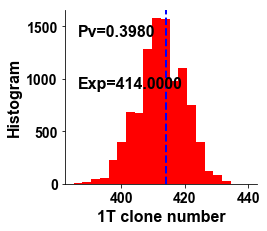

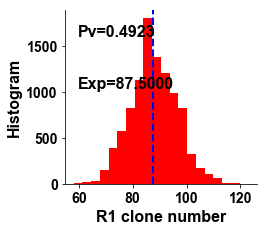

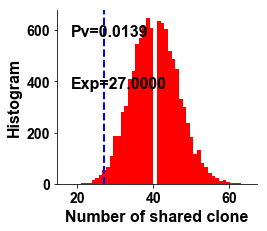

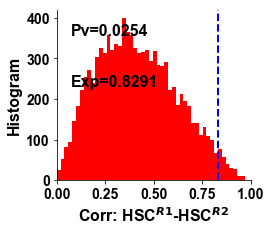

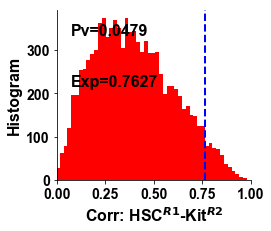

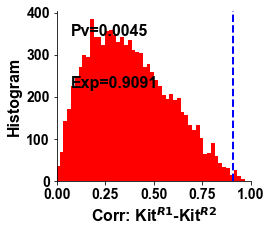

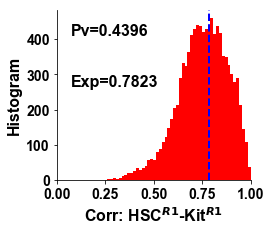

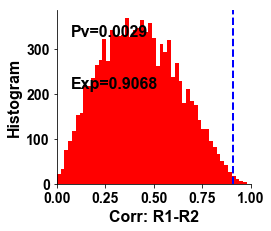

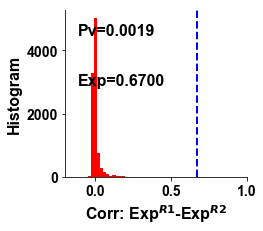

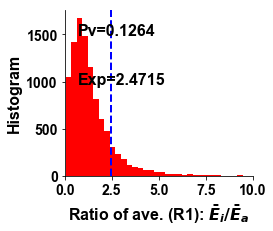

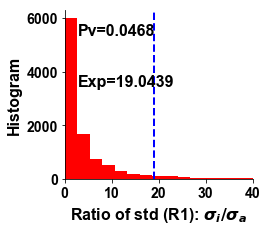

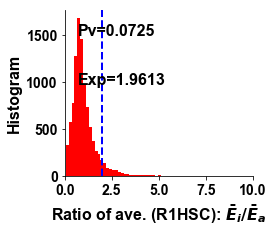

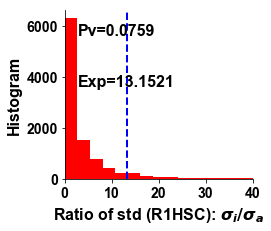

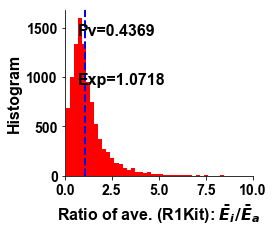

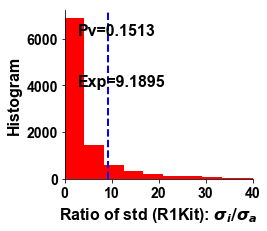

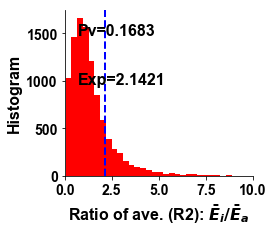

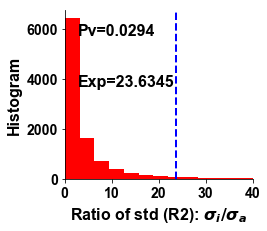

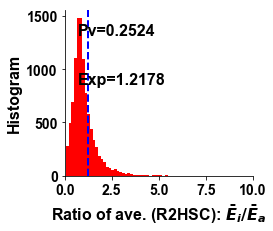

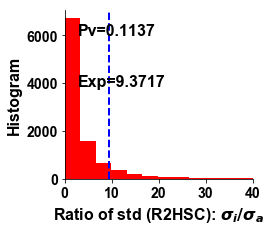

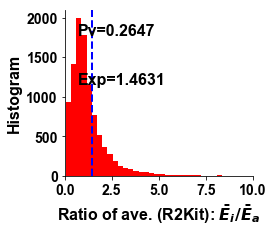

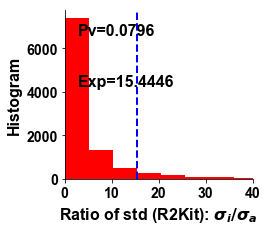

In [19]:
############ FOR R1 and R2

simu_data=N_clone_T1_array;  bin_N=20; exp_point=rp.clone_N_T1; xlim=[]; xlabel="1T clone number";  
mean_std_T1_clone_size=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);


simu_data=N_clone_T2R1_array;  bin_N=20; exp_point=(rp.clone_N_T2R2+rp.clone_N_T2R1)/2; xlim=[]; xlabel="R1 clone number";  
mean_std_R1_clone_size=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);
# simu_data=N_clone_T2R2_array;  bin_N=20; exp_point=rp.clone_N_T2; xlim=[]; xlabel="R2 clone size";  
# hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=N_shared_clone_array_T1R1R2;  bin_N=50; exp_point=27; xlim=[]; xlabel="Number of shared clone";  
mean_std_shared_clone_size=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T2R1HSC_T2R2HSC_array;  bin_N=50; exp_point=rp.corr_R1HSC_R2HSC; xlim=[0,1]; xlabel="Corr: HSC"+r"$^{R1}$"+"-HSC"+r"$^{R2}$";  
mean_std_R1HSC_R2HSC=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T2R1HSC_T2R2Kit_array;  bin_N=50; exp_point=rp.corr_R1HSC_R2Kit; xlim=[0,1]; xlabel="Corr: HSC"+r"$^{R1}$"+"-Kit"+r"$^{R2}$";  
mean_std_R1HSC_R2Kit=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T2R1Kit_T2R2Kit_array;  bin_N=50; exp_point=rp.corr_R1Kit_R2Kit; xlim=[0,1]; xlabel="Corr: Kit"+r"$^{R1}$"+"-Kit"+r"$^{R2}$";  
mean_std_R1Kit_R2Kit=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T2R1HSC_T2R1Kit_array;  bin_N=50; exp_point=rp.corr_R1HSC_R1Kit; xlim=[0,1]; xlabel="Corr: HSC"+r"$^{R1}$"+"-Kit"+r"$^{R1}$";  
mean_std_R1HSC_R1Kit=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data=Corr_simu_T2R1tot_T2R2tot_array;  bin_N=50; exp_point=rp.corr_R1cloneR2clone; xlim=[0,1]; xlabel="Corr: R1-R2";  
mean_std_R1_R2=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);

simu_data= Corr_simu_T2R1T2R2_expansion;  bin_N=50; exp_point=0.67; xlim=[-0.2,1]; xlabel="Corr: Exp"+r"$^{R1}$"+"-Exp"+r"$^{R2}$";  
mean_std_R1Exp_R2Exp=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,xlabel);


simu_data=Mean_ratio_array_T1R1;  bin_N=50; exp_point=rp.mean_ratio_T1R1; xlim=[0,10]; xlabel="Ratio of ave. (R1): "+r"$\bar{E}_i/\bar{E}_a$"; file_name="mean_ratio-R1"  
mean_std_mean_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=std_ratio_array_T1R1;  bin_N=50; exp_point=rp.std_ratio_T1R1; xlim=[0,40]; xlabel="Ratio of std (R1): "+r"$\sigma_i/\sigma_a$"; file_name="Std_ratio-R1"  
mean_std_std_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=Mean_ratio_array_HSC_T1R1;  bin_N=50; exp_point=rp.mean_ratio_HSC_T1R1; xlim=[0,10]; xlabel="Ratio of ave. (R1HSC): "+r"$\bar{E}_i/\bar{E}_a$"; file_name="mean_ratio-R1HSC"  
mean_std_mean_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=std_ratio_array_HSC_T1R1;  bin_N=50; exp_point=rp.std_ratio_HSC_T1R1; xlim=[0,40]; xlabel="Ratio of std (R1HSC): "+r"$\sigma_i/\sigma_a$"; file_name="Std_ratio-R1HSC"  
mean_std_std_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=Mean_ratio_array_Kit_T1R1;  bin_N=50; exp_point=rp.mean_ratio_Kit_T1R1; xlim=[0,10]; xlabel="Ratio of ave. (R1Kit): "+r"$\bar{E}_i/\bar{E}_a$"; file_name="mean_ratio-R1Kit"  
mean_std_mean_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=std_ratio_array_Kit_T1R1;  bin_N=50; exp_point=rp.std_ratio_Kit_T1R1; xlim=[0,40]; xlabel="Ratio of std (R1Kit): "+r"$\sigma_i/\sigma_a$"; file_name="Std_ratio-R1Kit"  
mean_std_std_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);


simu_data=Mean_ratio_array_T1R2;  bin_N=50; exp_point=rp.mean_ratio_T1R2; xlim=[0,10]; xlabel="Ratio of ave. (R2): "+r"$\bar{E}_i/\bar{E}_a$"; file_name="mean_ratio-R2"  
mean_std_mean_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=std_ratio_array_T1R2;  bin_N=50; exp_point=rp.std_ratio_T1R2; xlim=[0,40]; xlabel="Ratio of std (R2): "+r"$\sigma_i/\sigma_a$"; file_name="Std_ratio-R2"  
mean_std_std_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=Mean_ratio_array_HSC_T1R2;  bin_N=50; exp_point=rp.mean_ratio_HSC_T1R2; xlim=[0,10]; xlabel="Ratio of ave. (R2HSC): "+r"$\bar{E}_i/\bar{E}_a$"; file_name="mean_ratio-R2HSC"  
mean_std_mean_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=std_ratio_array_HSC_T1R2;  bin_N=50; exp_point=rp.std_ratio_HSC_T1R2; xlim=[0,40]; xlabel="Ratio of std (R2HSC): "+r"$\sigma_i/\sigma_a$"; file_name="Std_ratio-R2HSC"  
mean_std_std_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=Mean_ratio_array_Kit_T1R2;  bin_N=50; exp_point=rp.mean_ratio_Kit_T1R2; xlim=[0,10]; xlabel="Ratio of ave. (R2Kit): "+r"$\bar{E}_i/\bar{E}_a$"; file_name="mean_ratio-R2Kit"  
mean_std_mean_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);

simu_data=std_ratio_array_Kit_T1R2;  bin_N=50; exp_point=rp.std_ratio_Kit_T1R2; xlim=[0,40]; xlabel="Ratio of std (R2Kit): "+r"$\sigma_i/\sigma_a$"; file_name="Std_ratio-R2Kit"  
mean_std_std_ratio=hf.plot_histogram_with_a_line(simu_data,bin_N,exp_point,xlim,fig_dir,xlabel,file_name);





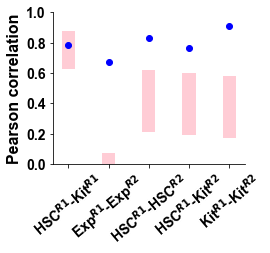

In [20]:
# data to plot

%run my_fig_config_0
simu_mean = np.array([mean_std_R1HSC_R1Kit[0],mean_std_R1Exp_R2Exp[0],mean_std_R1HSC_R2HSC[0],mean_std_R1HSC_R2Kit[0], mean_std_R1Kit_R2Kit[0]])
simu_std = np.array([mean_std_R1HSC_R1Kit[1],mean_std_R1Exp_R2Exp[1],mean_std_R1HSC_R2HSC[1],mean_std_R1HSC_R2Kit[1], mean_std_R1Kit_R2Kit[1]] )
real_data = np.array([mean_std_R1HSC_R1Kit[2],mean_std_R1Exp_R2Exp[2],mean_std_R1HSC_R2HSC[2],mean_std_R1HSC_R2Kit[2], mean_std_R1Kit_R2Kit[2]])
 
fig = plt.figure(figsize=(4,3.8)); ax = fig.add_subplot(1, 1, 1)
index = np.arange(len(simu_mean))
bar_width = 0.33
opacity = 0.8


 
# ax.bar(index,real_data,bar_width,alpha=opacity,color='pink')
# ax.errorbar(index,simu_mean,simu_std, fmt='^b',ecolor='darkgreen')

ax.bar(index,simu_mean-simu_std,bar_width,alpha=opacity,color='white')
ax.bar(index,2*simu_std,bar_width,alpha=opacity,color='pink',bottom=simu_mean-simu_std,label='Null model')
ax.plot(index,real_data,"ob",label='Data')

    
#plt.xlabel('Person')
ax.set_ylabel('Pearson correlation')
#plt.title('')
plt.xticks(index, ("HSC"+r"$^{R1}$"+"-Kit"+r"$^{R1}$", "Exp"+r"$^{R1}$"+"-Exp"+r"$^{R2}$","HSC"+r"$^{R1}$"+"-HSC"+r"$^{R2}$","HSC"+r"$^{R1}$"+"-Kit"+r"$^{R2}$", "Kit"+r"$^{R1}$"+"-Kit"+r"$^{R2}$"),rotation=40)
#ax.legend(frameon=False)
ax.set_ylim([0,1]) 
    
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tight_layout()
plt.show()
fig.savefig(fig_dir+"R1R2_correlation_paper.eps")

In [21]:
# save variables in python file
with open(data_dir+"corr_mean_std_R1R2.py",'w') as file:
    file.write("mean_std_R1HSC_R1Kit={}\n".format(mean_std_R1HSC_R1Kit));
    file.write("mean_std_R1HSC_R2HSC={}\n".format(mean_std_R1HSC_R2HSC));
    file.write("mean_std_R1HSC_R2Kit={}\n".format(mean_std_R1HSC_R2Kit));
    file.write("mean_std_R1Kit_R2Kit={}\n".format(mean_std_R1Kit_R2Kit));
    file.write("mean_std_R1Exp_R2Exp={}\n".format(mean_std_R1Exp_R2Exp));
    
    
    
